In [40]:
!pip install --quiet gensim

In [48]:
import pandas as pd

#shuffle this so the negatives/positives are mixed
yelps = pd.read_csv('sentiment/yelps.csv').sample(frac=1).reset_index(drop=True)

In [49]:
from bs4 import BeautifulSoup

def clean_yelp(s):
    s = BeautifulSoup(s, 'html5lib').get_text()
    s = ' '.join(s.split())
    s = s.strip().lower()
    return s

def tokenize(s):
    """ Returns a list of strings (tokens) from the document """

    # Implement this function!
    # Hint: If you look at the sklearn source code on github, 
    # you will find a good regular expression they use as a default
    # tokenizer in CountVectorizer -- this is the tokenizer
    # we have been using until now!
    # But you need to implement your own now. 
    
    #Token Pattern:
    pattern = r"(?u)\b\w\w+\b"
    pattern = re.compile(pattern)
    return pattern.findall(s)


In [50]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
import re

# Create a count vectorizer, using the preprocessor and tokenizer from above
vectorizer = CountVectorizer(preprocessor = clean_yelp, tokenizer = tokenize)
yelp_transform = vectorizer.fit_transform(yelps.text) # fit this vectorizer to yelp data

# use TruncatedSVD from Sklearn to generate a term embedding matrix for your data
# that is 100 dimensional in size.
svd = TruncatedSVD(n_components=100)

# Embed your documents via that term embedding matrix (this is just the PCA of the 
# TF matrix, as returned by "transform" on TruncatedSVD
yelp_trun = svd.fit_transform(yelp_transform)

/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:336: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:273: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [51]:
# Here you should have TWO vector representations of your Yelp data: 
# 1. The original TF matrix
# 2. The first 100 components of the PCA of that matrix, as performed by TruncatedSVD
# check matrix sizes 
print("Original TF Matrix size: ", yelp_transform.shape)
print("PCA of TF Matrix: ", yelp_trun.shape)

Original TF Matrix size:  (100000, 78364)
PCA of TF Matrix:  (100000, 100)


In [52]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

def test_holdout_vectors(V, y, cutoff):
    model = LogisticRegression()
    model.fit(V[:cutoff], y[:cutoff])
    preds = model.predict(V[cutoff:])
    return accuracy_score(preds, y[cutoff:])

# Didn't change this function

In [53]:
# Test your vector representations using the above function, test_holdout_vectors. 
# for several levels of "cutoff". 

percents = [.05, .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7, .75]

# cutoff levels to check
cut_levels  = []

for percent in percents:
    cut_levels.append(int(len(yelps.positive) * percent))

# levels: [5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 
#          50000, 55000, 60000, 65000, 70000, 75000]


In [54]:
OG_accuracy_yelp = [test_holdout_vectors(yelp_transform, yelps.positive, cut) for cut in cut_levels]

Trunc_accuracy_yelp = [test_holdout_vectors(yelp_trun, yelps.positive, cut) for cut in cut_levels]

# This function simulates training on a small part of your data and testing on the rest.
# Thus, it's as though you have some labelled data but a bunch of unlabelled data. 
# This is essentially a semi-supervised situation. 

Text(0.5,1,'Full Model vs. PCA Word Embeddings of Yelp Reviews')

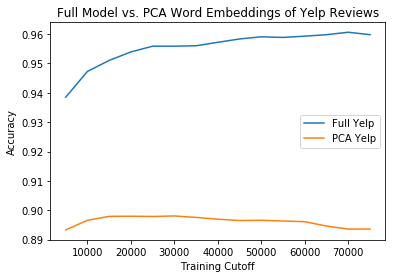

In [60]:
from matplotlib import pyplot as plt

plt.plot(cut_levels, OG_accuracy_yelp)
plt.plot(cut_levels, Trunc_accuracy_yelp)
plt.legend(['Full Yelp', 'PCA Yelp'])
plt.xlabel('Training Cutoff')
plt.ylabel('Accuracy')
plt.title('Full Model vs. PCA Word Embeddings of Yelp Reviews')

# Do the word embeddings generated via SVD allow you to pull information from the 
# unlabeled data and improve your score given a small training set? 

In [66]:
## How many cores does my computer have
import multiprocessing
multiprocessing.cpu_count()
# 8

8

In [67]:
from gensim.models import Word2Vec

# Next, create another term embedding via Word2Vec, also 100 dimensional
# Look at the documentation from the library gensim and see what hyperparameters
# you can choose to tune. 
# Note: training takes time, so you probably won't want to try too many!

sentences = yelps.text.apply(clean_yelp).apply(tokenize)

model1 = Word2Vec(sentences, window = 5, min_count = 5, workers = 8)

model2 = Word2Vec(sentences, window = 10, min_count = 5, workers = 8)

# pass the cleaned and tokenized yelp reviews as "sentences" to your model
# to build the vocabulary and train the word vectors. 


/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:336: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:273: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [68]:
import numpy as np

def embed_w2v(tokens, w2v):
    idxs = [w2v.wv.vocab.get(t) for t in tokens]
    idxs = [t.index for t in idxs if t]
    N = w2v.wv.vectors.shape[1]
    if len(idxs) < 1:
        return np.zeros(N)
    a = np.sum(w2v.wv.vectors[idxs, :], axis=0)
    a /= np.linalg.norm(a)
    return a

# use as follows: np.array([embed_w2v(t, w2v) for t in X])

In [70]:
# use the embed_w2v function to embed your Yelp reviews using the new
# word2vec word embeddings. Each review will be a normalized sum of the
# words that it is made of. 
# See how this improves the scores in the classification task using
# test_holdout_vectors -- is word2vec better? At what training-set sizes does it help
# more? 

# Model 1:
w2v_matrix_1 = np.array([embed_w2v(t, model1) for t in sentences])
w2v_accuracy_1 = [test_holdout_vectors(w2v_matrix_1, yelps.positive, cut) for cut in cut_levels]

# Model 2:
w2v_matrix_2 = np.array([embed_w2v(t, model2) for t in sentences])
w2v_accuracy_2 = [test_holdout_vectors(w2v_matrix_2, yelps.positive, cut) for cut in cut_levels]


Text(0.5,1,'Relative Accuracy across Models')

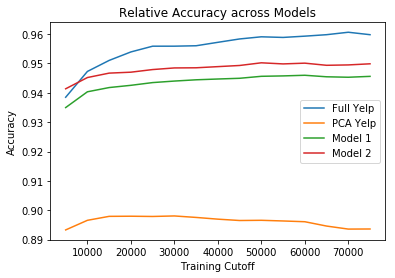

In [71]:
# Plot it to see relative accuracy

plt.plot(cut_levels, OG_accuracy_yelp)
plt.plot(cut_levels, Trunc_accuracy_yelp)
plt.plot(cut_levels, w2v_accuracy_1)
plt.plot(cut_levels, w2v_accuracy_2)

plt.legend(['Full Yelp', 'PCA Yelp', "Model 1", "Model 2"])
plt.xlabel('Training Cutoff')
plt.ylabel('Accuracy')
plt.title('Relative Accuracy across Models')


#See how this improves the scores in the classification task using test_holdout_vectors -- is word2vec better? At what training-set sizes does it help more? 

It improves upon the full model (no PCA) but it does not beat the accuracy of the PCA model. A smaller window (model 1) performed better than a larger one. At smaller sample sizes o the training cutoff the models were closer together in accuracy but at every single size the PCA version vastly outperforms the other models.


In [87]:
import pandas as pd
from functools import reduce

pd.set_option('max_colwidth', 80)

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE, MDS
import seaborn as sns
import re
import spacy
nlp = spacy.load("en")
import emoji
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


# Here is my function from exercise 1:

def clean_twitter(s):
    """ Cleans Twitter specific issues
    
    Should probably clean out mentions, URLs, and RT's.
    """

    # TODO: Use regular expressions to remove unwanted
    # text and clean up our tweets to be more usable!
    
    # syntax: sub("bad thing", "desired thing", your object to store it)
    
    # twitter stuff
    s = re.sub("@", " ", s) ##mentions
    s = re.sub("RT", "", s) ##retweets
    s = re.sub("#", "", s) ##hashtag identifier
    s = emoji.demojize(s) ##emojis
    
    # unwanted symbols/punctuations
    s = re.sub("%", " percent", s) ##percents
    s = re.sub("&amp;", "and", s) ##ampersands
    s = re.sub("&gt;", "more", s) ##more than
    s = re.sub("&lt;3", "love", s) ##<3 heart
    s = re.sub("&lt;", "less", s) ##less than
    s = re.sub("'s", "", s) ##possessive or contraction
    s = re.sub("'re", "", s) ##contraction
    s = re.sub("'ll", "", s) ##contraction
    
    # typical text mining things
    s = re.sub("\n", "", s) ##line breaks
    s = re.sub(r"http\S+", "", s) ##hyperlinks
    s = s.lower() ##case sensitivity

    
    # BONUS: Try using the library "spacy" to 
    
    doc = nlp(s) ##from spacy website
    
    # do further processing, such as lemmatizing
    
    for token in doc:
        if not token.is_punct | token.is_stop:
            " ".join(token.lemma_)
    
    # or replacing Named Entities with constants (i.e. "[NAMED]")
    # or adding the part of speech or dependency code to the word 

    return s

In [88]:
# Load tweet
# NOTE: this file needs to be downloaded from Box! 

with open('tweets/tweets.txt') as f:
    tweets = pd.Series(f.readlines())

In [89]:
# Now embed this twitter data, again using Word2Vec and LSA (SVD)
# you don't have any labels, but you might be able to 
# find some interesting phenomena. 

vectorizer2 = CountVectorizer(preprocessor=clean_twitter)
tweet_transform = vectorizer2.fit_transform(tweets) # fit this vectorizer to yelp data

# use TruncatedSVD from Sklearn to generate a term embedding matrix for your data
# that is 100 dimensional in size.
svd2 = TruncatedSVD(n_components=100)

# Embed your documents via that term embedding matrix (this is just the PCA of the 
# TF matrix, as returned by "transform" on TruncatedSVD
tweet_trun = svd2.fit_transform(tweet_transform)

In [96]:
# Next, create another term embedding via Word2Vec, also 100 dimensional
# Note: training takes time, s8o you probably won't want to try too many!

sentences2 = [clean_twitter(t).split(' ') for t in tweets]

model_tweet = Word2Vec(sentences2, window = 5, min_count = 5, workers = 8)


In [97]:
# use the embed_w2v function to embed your tweets using the new
# word2vec word embeddings. Each tweet will be a normalized sum of the
# words that it is made of. 

# Model:
w2v_matrix_tweet = np.array([embed_w2v(t, model_tweet) for t in sentences2])


In [98]:
# Explore using either or both of the following tools: 
# 1. Word2Vec has a built in feature for getting most similar
# words, including via positive/negative examples (subtraction)
# What happens when you subtract "hillary" from "trump"? 
display(model_tweet.wv.most_similar('trump'))
display(model_tweet.wv.most_similar('hillary'))
display(model_tweet.wv.most_similar(positive=['trump'], negative=['hillary']))

[('Trump', 0.6930238008499146),
 ('Bernie', 0.5703309774398804),
 ('Trumps', 0.5570036768913269),
 ('TRUMP', 0.5064427256584167),
 ('him', 0.4805147349834442),
 ('establishment', 0.46162575483322144),
 ('GOP', 0.45076021552085876),
 ('MAGA', 0.4464823603630066),
 ('Rubio', 0.4456547498703003),
 ('crowd', 0.4431156516075134)]

[('Hilary', 0.6447988748550415),
 ('HIllary', 0.6136683225631714),
 ('Robby', 0.6090949177742004),
 ('Lea', 0.585345983505249),
 ('Mook', 0.5842788219451904),
 ('Hitlery', 0.5837231874465942),
 ('shes', 0.5768044590950012),
 ('Hiliary', 0.5764229893684387),
 ('cruz', 0.5735346674919128),
 ('Adriana', 0.5675225257873535)]

[('South', 0.4422275125980377),
 ('Trump', 0.4420125484466553),
 ('live', 0.4202693998813629),
 ('tomorrow', 0.41975098848342896),
 ('rally', 0.41649484634399414),
 ('tonight', 0.4098624289035797),
 ('protest', 0.409775048494339),
 ('crowd', 0.4028104841709137),
 ('march', 0.3994060754776001),
 ('NFC', 0.39300596714019775)]

In [ ]:
# Bonus: build a similar feature for your LSA features and
# see if you can do similar vector math

# My model took so long to run that I don't have time for this in the scheme of things

In [99]:
from scipy.spatial.distance import pdist,squareform
import seaborn as sns

def visualize_dist(V, tweets, idxs):
    """ Visualize distances in heatmap

    V is the vector of embeddings 
    tweets is a list or series that converts from idx to tweet
    idxs is a list of integers that you would like to compare (<= 5 probably)
    """
    m = squareform(pdist(V[idxs], 'cosine'))
    _ = sns.heatmap(pd.DataFrame(m, columns = tweets[idxs], index= tweets[idxs]))

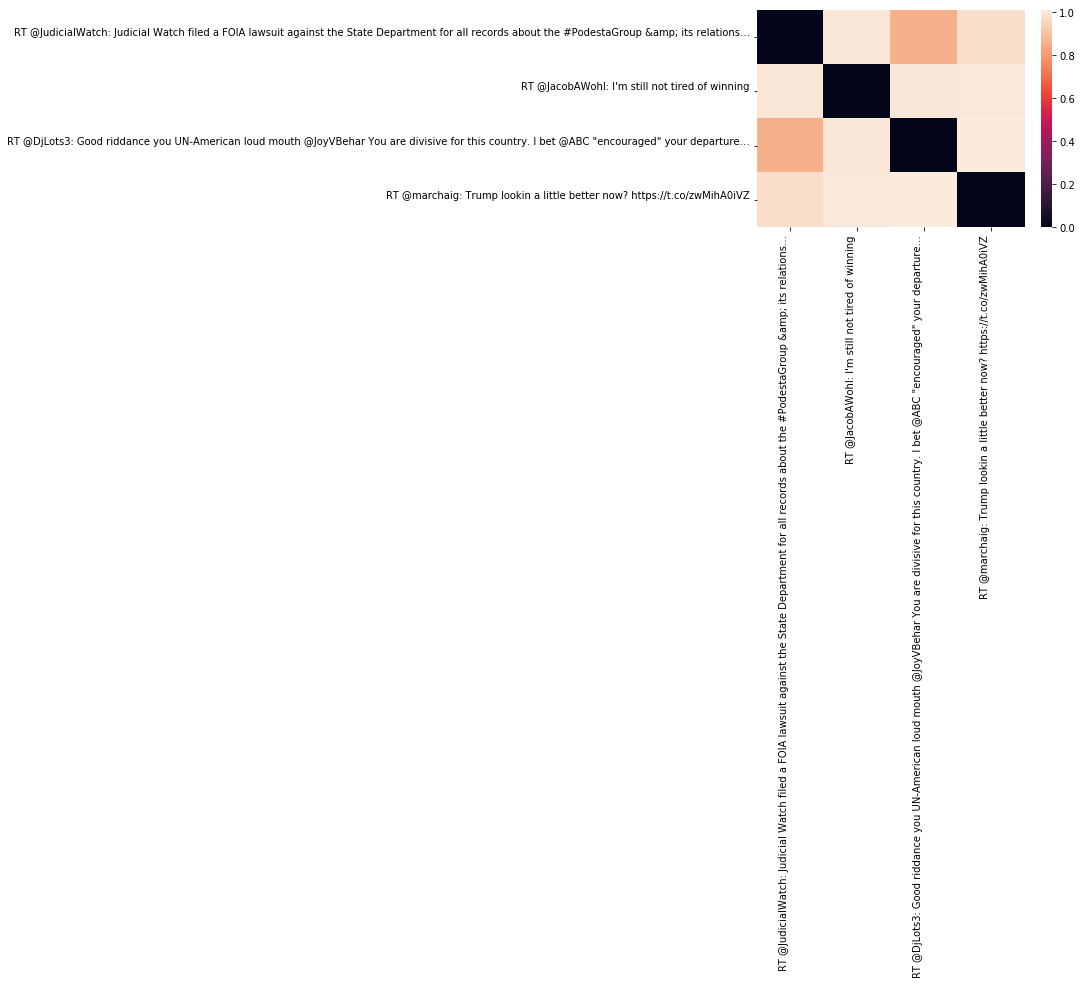

In [105]:
# 2. Use the visualize_dist function to see how
# the tweet-tweet distance looks for a selection
# of random tweets. Do you agree with the distance? 
# Does one embedding seem better than another? 

idx = np.random.randint(0, high=len(tweets), size=4)
visualize_dist(tweet_trun, tweets, idx)

## All the tweets are so different that of course their difference score is high. So yes I agree.
## Would be more interesting to find similar tweets

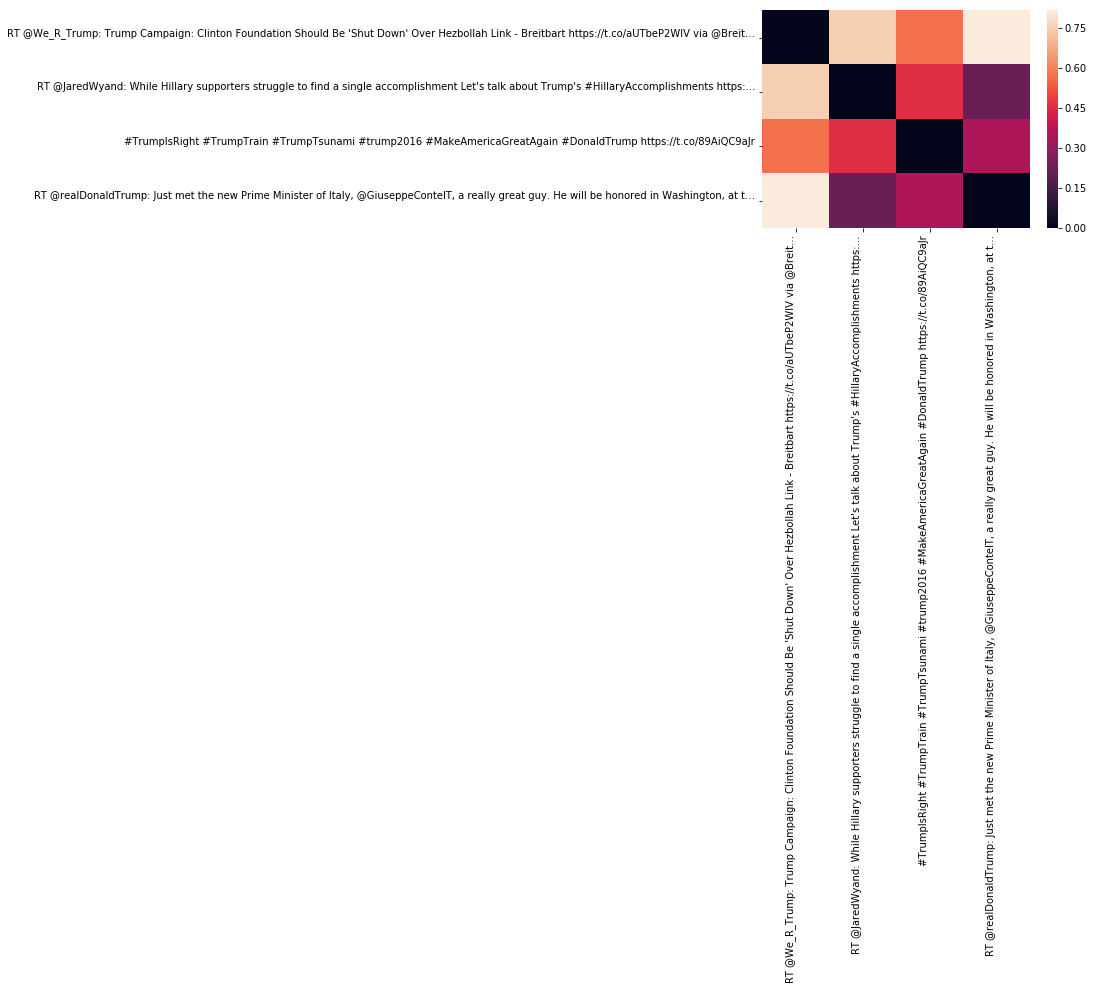

In [106]:
idx = np.random.randint(0, high=len(tweets), size=4)
visualize_dist(w2v_matrix_tweet, tweets, idx)

#Both tweet 2 and 4 are highly complimentary to trump and they rank very similar! Cool to see!
#Hard to say if this does "better" than the other however because maybe it would give the same rankings...
#With only 4 random tweets it's hard to analyze which does better. This does well though

In [107]:
# More bonus!
# Use one of the following pre-embedded models and see if your yelp scores improve? 
# What about your Twitter explorations?

# https://github.com/RaRe-Technologies/gensim-data

import gensim.downloader as api
google_model = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [108]:

# Model Google for Yelp:
w2v_Google = np.array([embed_w2v(t, google_model) for t in yelps.text.apply(clean_yelp).apply(tokenize)])


/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:336: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:273: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:273: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `w

In [109]:
goog_accuracy = [test_holdout_vectors(w2v_Google, yelps.positive, cut) for cut in cut_levels]


Text(0.5,1,'Relative Accuracy across Models')

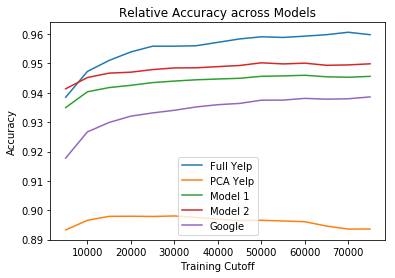

In [110]:
# Plot it to see relative accuracy in relation to my earlier models

plt.plot(cut_levels, OG_accuracy_yelp)
plt.plot(cut_levels, Trunc_accuracy_yelp)
plt.plot(cut_levels, w2v_accuracy_1)
plt.plot(cut_levels, w2v_accuracy_2)
plt.plot(cut_levels, goog_accuracy)


plt.legend(['Full Yelp', 'PCA Yelp', "Model 1", "Model 2", "Google"])
plt.xlabel('Training Cutoff')
plt.ylabel('Accuracy')
plt.title('Relative Accuracy across Models')


Google does better than most, but the PCA was still outstanding in comparison!